In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lora_modem import LoraModulator, LoraCorrelationSynchronizer

# LoRa Synchronization

In [2]:
import numpy as np
from lora_modem import LoraDemodulator
class SimpleLoraSynchronizer:
    """Class that implements a simple synchronization of LoRa signals using cross-correlation."""

    def validate_parameters(self, spreading_factor, samples_per_chip, bandwidth, sync_basis):
        if spreading_factor not in range(7, 13) or not isinstance(spreading_factor, int):
            raise ValueError('The spreading factor must be an integer between 7 and 12.')
        if samples_per_chip < 1 or not isinstance(samples_per_chip, int):
            raise ValueError('Samples per chip must be a positive integer')
        if bandwidth <= 0:
            raise ValueError('Bandwidth must be positive')
        if not isinstance(sync_basis, np.ndarray):
            raise ValueError('sync_basis must be a numpy array')

    def __init__(self, spreading_factor, samples_per_chip, bandwidth, sync_basis):
        self.validate_parameters(spreading_factor, samples_per_chip, bandwidth, sync_basis)
        self._spreading_factor = spreading_factor
        self._samples_per_chip = samples_per_chip
        self._bandwidth = bandwidth
        self._sync_basis = sync_basis
        self._demodulator = LoraDemodulator(spreading_factor, bandwidth, samples_per_chip)

    def _get_samples_per_symbol(self):
        """Helper function to calculate the number of samples per symbol."""
        return self._samples_per_chip * 2 ** self._spreading_factor

    def synchronize_rx_buffer(self, rx_buffer):
        """
        Synchronizes the received buffer by finding the start and end of the payload.

        Parameters:
        rx_buffer (np.ndarray): The received signal buffer.

        Returns:
        np.ndarray: The synchronized payload segment.
        """
        # Find the start of the message
        buffer_without_preamble = self._synchronize_start(rx_buffer)
        if buffer_without_preamble.size == 0:
            print('Synchronization failed during start synchronization!')
            return None

        # Find the end of the message
        payload = self._synchronize_end(buffer_without_preamble)
        if payload.size == 0:
            print('Synchronization failed during end synchronization!')
            return None

        return payload

    def _synchronize_start(self, rx_buffer):
        """
        Finds the start of the message body in rx_buffer using cross-correlation with sync_basis.
        """
        # Perform cross-correlation
        corr = np.correlate(rx_buffer, self._sync_basis, mode='full')
        
        # Find the index where the correlation is maximum
        i_max = np.argmax(np.abs(corr))
        
        # Calculate the lag corresponding to the maximum correlation
        lag = i_max - (len(self._sync_basis) - 1)
        
        if lag < 0:
            print("Warning: The synchronization basis extends beyond the start of the reception buffer.")
            lag = 0  # Adjust lag to 0 if negative
        
        print(f"Synchronization pattern start found at index {lag}")
        
        # Calculate the index where the message body starts
        message_start = lag + len(self._sync_basis)
        
        # Check that the index does not exceed the buffer length
        if message_start >= len(rx_buffer):
            print("Warning: The message start index exceeds the reception buffer length.")
            return np.array([])  # Return an empty array if the index is invalid
        
        print(f"Message body start found at index {message_start}")
        
        # Return the buffer from the message body start
        return rx_buffer[message_start:]

    def _synchronize_end(self, buffer_without_preamble):
        """
        Finds the end of the buffer by determining the payload length from the first symbol.

        Parameters:
        buffer_without_preamble (np.ndarray): The received signal buffer without the preamble.

        Returns:
        np.ndarray: The payload segment of the received signal.
        """
        samples_per_symbol = self._get_samples_per_symbol()
        # Demodulate the payload length symbol
        payload_length_signal = buffer_without_preamble[:samples_per_symbol]
        payload_length = self._demodulator.demodulate_symbol(payload_length_signal)
        payload_start = samples_per_symbol  # Skip the length symbol
        payload_end = payload_start + payload_length * samples_per_symbol
        if payload_end > len(buffer_without_preamble):
            print("Warning: The payload end index exceeds the buffer length.")
            return np.array([])  # Return an empty array if the index is invalid
        return buffer_without_preamble[payload_start:payload_end]


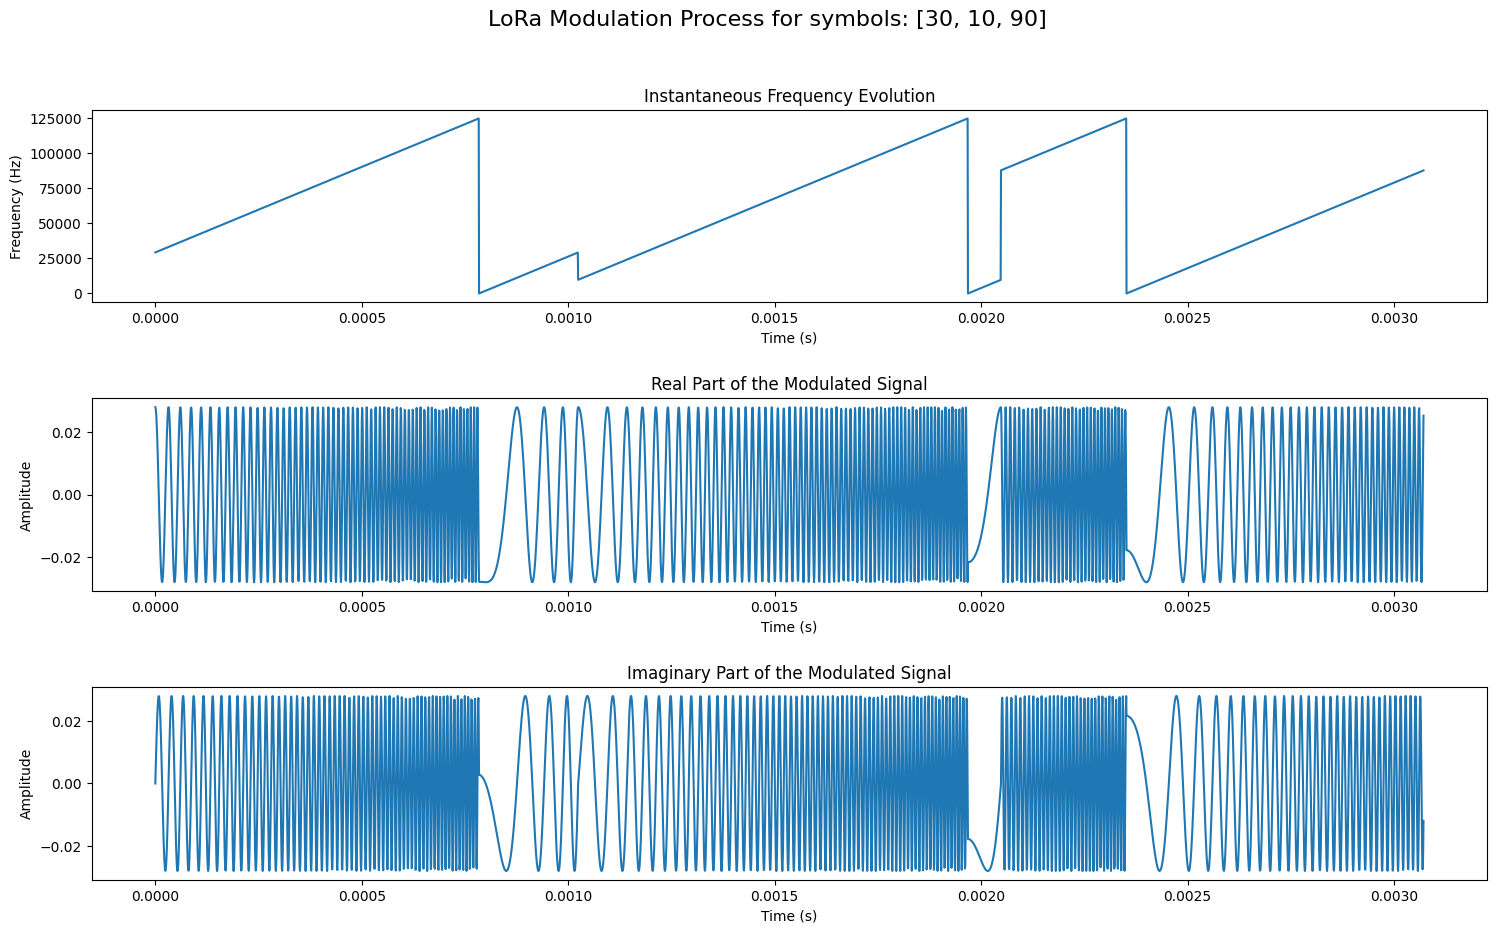

Synchronization pattern start found at index 8869
Message body start found at index 14309


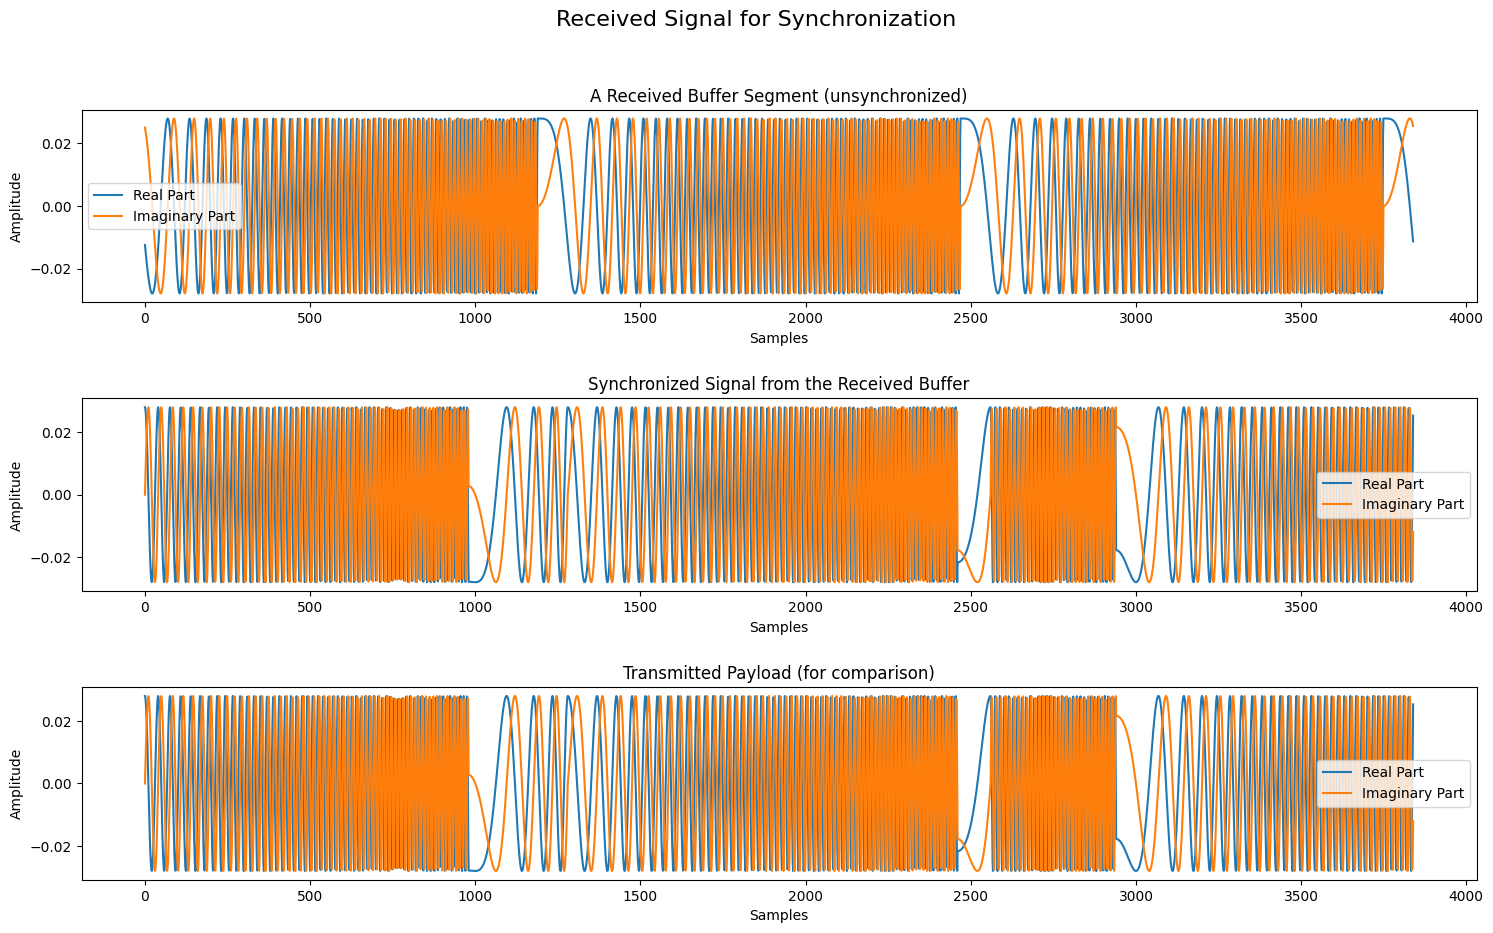

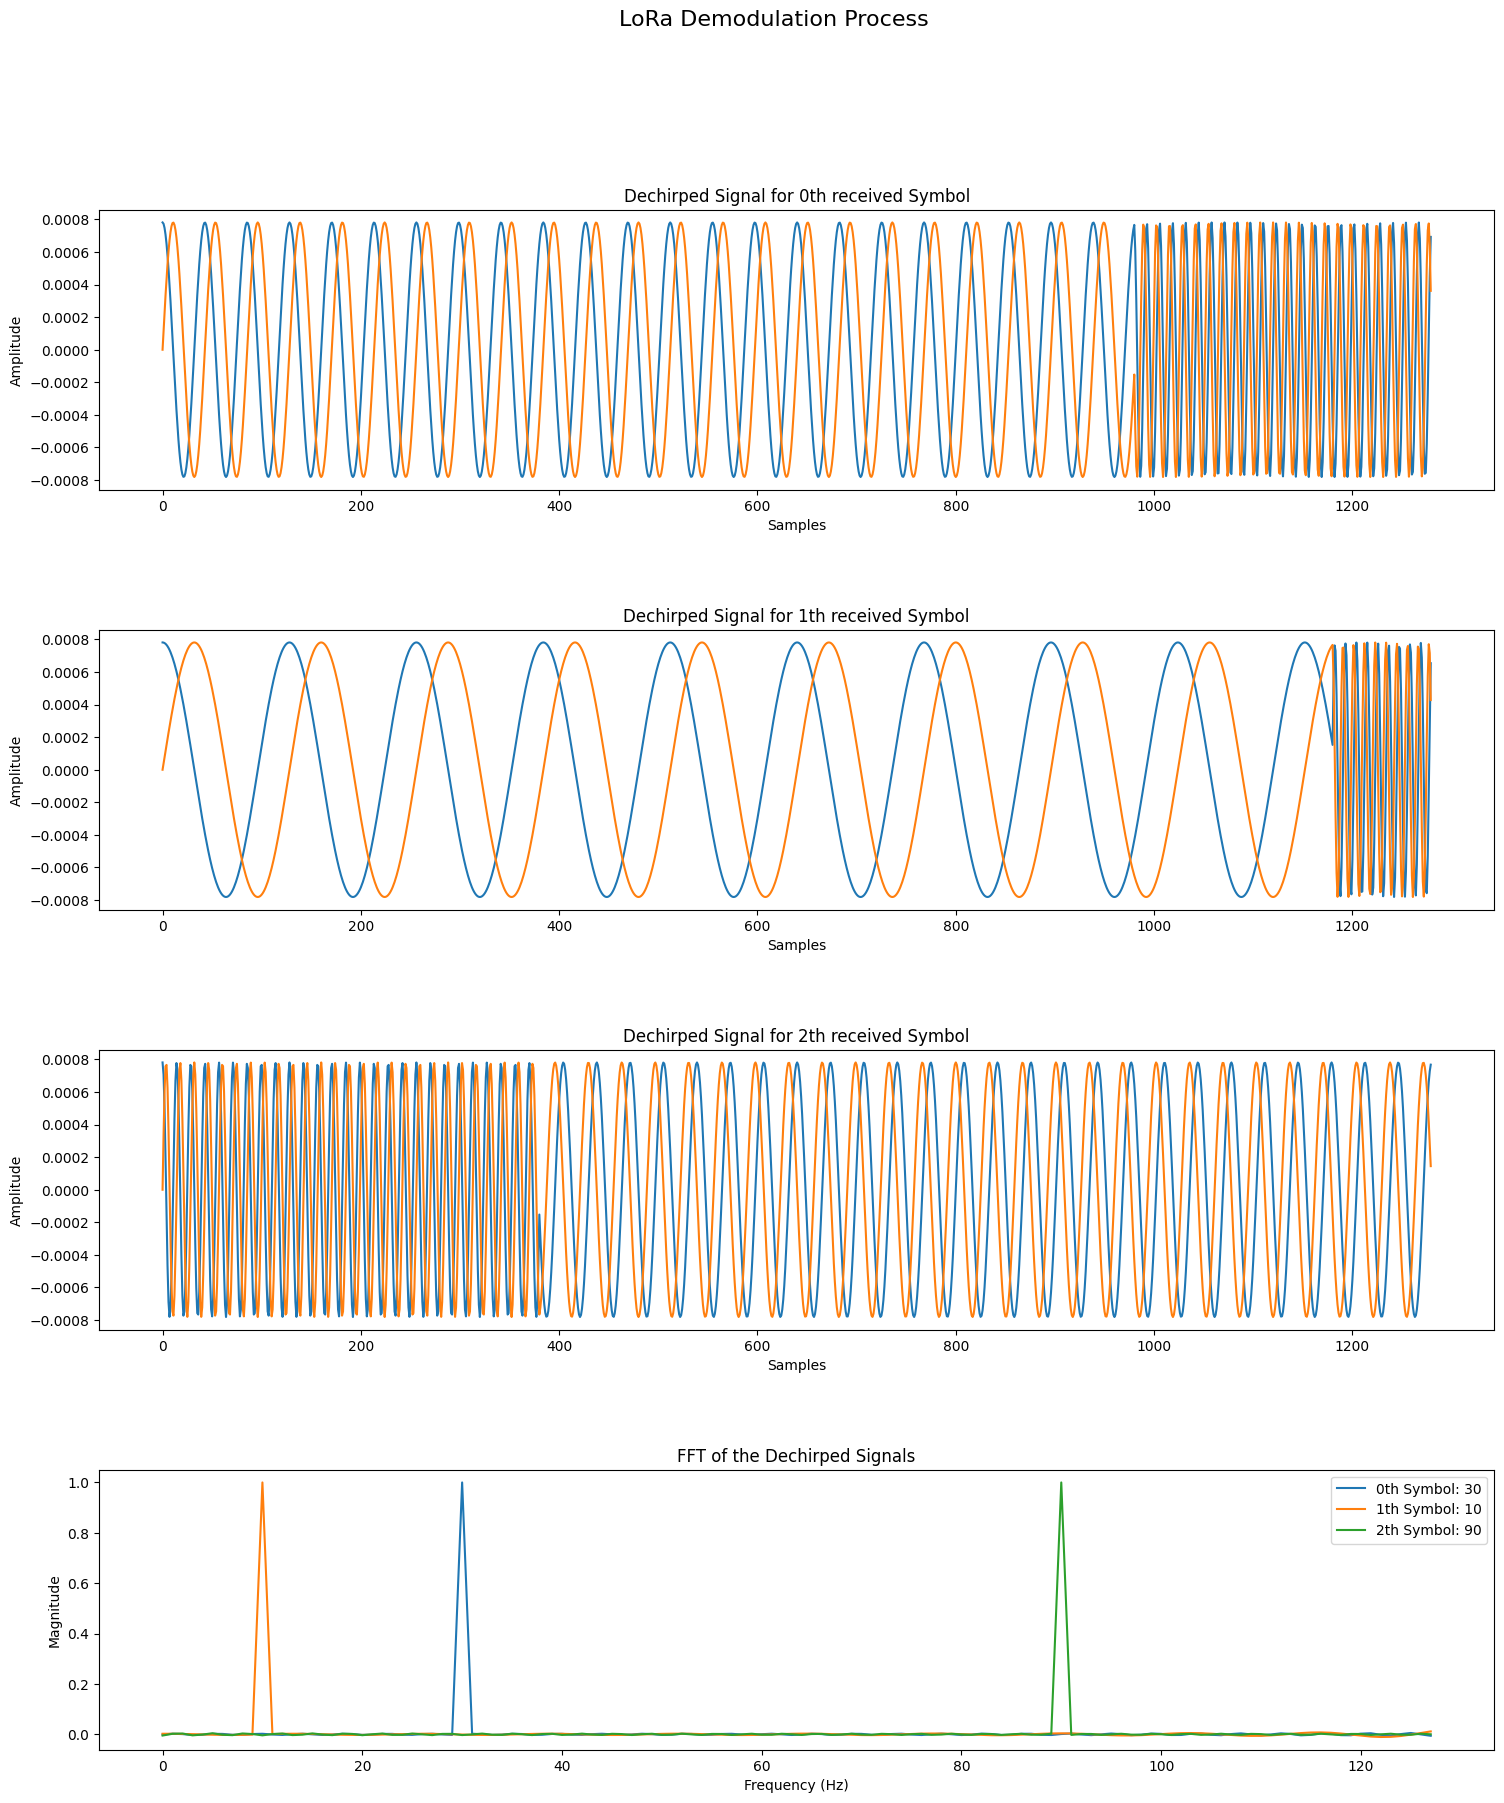

In [3]:
def ciclify(signal):
    """Shifts the signal in a cyclical nature to simulate a real-world scenario where the signal's first sample isn't alligned to the first received one."""
    rx_buffer = np.array([signal, signal, signal]).flatten()
    roll_factor = np.random.randint(0, len(rx_buffer)//2)
    rx_buffer = np.roll(rx_buffer, roll_factor)

    return rx_buffer


# ----- Playground -----
spreading_factor = 7
bandwidth = 125e3
samples_per_chip = 10
preamble_number = 8
payload = [30, 10, 90]

# Inicio el modulador, demodulador y sincronizador
modulator = LoraModulator(spreading_factor, bandwidth, samples_per_chip)
demodulator = LoraDemodulator(spreading_factor, bandwidth, samples_per_chip)
synchronizer = LoraCorrelationSynchronizer(spreading_factor, samples_per_chip, bandwidth, modulator.get_sync_basis())

# Modulo y ploteo el paquete para el payload especificado
pkg_signal, payload_signal = modulator.modulate_n_plot_explicit_package(preamble_number, payload, plot_with_preamble=False, return_payload_signal=True)

# "Ciclifico" el paquete para simular una recepción real de un SDR con transmisión de señal no alineada y cíclica
rx_buffer = ciclify(pkg_signal)

# Sincronizo el buffer recibido
sync_rx_payload = synchronizer.synchronize_rx_buffer(rx_buffer)

# Ploteo la sincronización
synchronizer.plot_synchronization(rx_buffer, sync_rx_payload, payload_signal)

if sync_rx_payload is not None:
    # Demodulo y ploteo los símbolos recibidos si la sincronización fue exitosa
    received_symbols = demodulator.demodulate_n_plot_symbols(sync_rx_payload)
    
